# Homework 3: Voxel-Based 3D Reconstruction
#### Name: Syed Zain Raza
#### CWID: 20011917

In [1]:
# optional: allow Jupyter to "hot reload" the modules we import - after each change, rerun this cell (instead of restarting the kernel!!)
%load_ext autoreload
%autoreload 2

## Step 1: Define a Voxel Grid

Note to Self: the hw description mentions the dimensions of the voxel grid are measured in **meters**.

In [2]:
import numpy as np

In [6]:
X_RESOLUTION, Y_RESOLUTION, Z_RESOLUTION = (50, 50, 50)  # hope this doesn't raise a OOM error later
X_MIN, Y_MIN, Z_MIN = (-2.5, -3, 0)
X_DISTANCE, Y_DISTANCE, Z_DISTANCE = (5, 6, 2.5)

In [7]:
x_axis = np.linspace(X_MIN, X_MIN + X_DISTANCE, X_RESOLUTION)
y_axis = np.linspace(Y_MIN, Y_MIN + Y_DISTANCE, Y_RESOLUTION)
z_axis = np.linspace(Z_MIN, Z_MIN + Z_DISTANCE, Z_RESOLUTION)

The next line is probably unnecessary - it's just that I find the `meshgrid()` function super dope:

In [48]:
x_coords, y_coords, z_coords = np.meshgrid(x_axis, y_axis, z_axis, indexing="ij")

## Step 2: Determine the Voxels Forming the Visual Hull

### Load the Silhouette Images and Camera Projection Matrices

Before anything else, let's play around to check if we can even load the projection matrix:

In [40]:
import xml.etree.ElementTree as ET

tree = ET.parse("../dancer/calibration/cam00.xml")
root = tree.getroot()
vals = [float(val) for val in root.text.split()]
cam_transform = np.array(vals).reshape(3, 4)
cam_transform

array([[ 7.76649963e+02, -2.98408539e+02, -3.20483860e+01,
         9.93158188e+02],
       [ 1.32852554e+02,  1.20885834e+02, -7.59210876e+02,
         1.98217400e+03],
       [ 7.44869000e-01,  6.62592000e-01, -7.83770000e-02,
         4.62931201e+00]])

Mission accomplished! Let's switch focus to seeing the silhouette images can be loaded:

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

from util import ops

Dimensions of ../dancer/silh_cam00_00023_0000008550.pbm: 582 x 780
[  0 255]


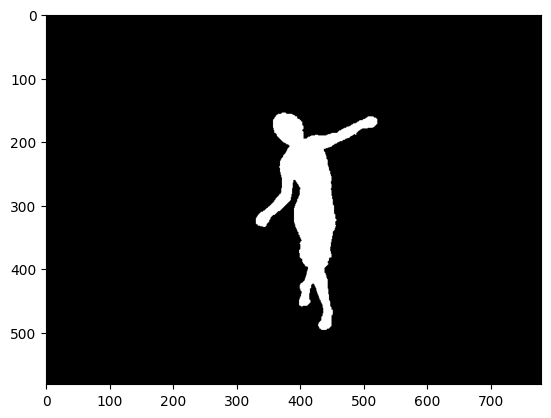

In [34]:
test_silhouette = ops.load_image(
    "../dancer/silh_cam00_00023_0000008550.pbm",
    return_grayscale=True,
    return_array=True
)
print(np.unique(test_silhouette))
plt.imshow(test_silhouette, cmap="gray")
plt.show()

In [44]:
import glob

cam_transform_paths = glob.glob("../dancer/calibration/*")
silhouette_paths = glob.glob("../dancer/silh*")

Let's confirm if `glob.glob()` indeed return paths that are relative, so we know they don't need too much further preprocessing:

In [47]:
cam_transform_paths

['../dancer/calibration/cam01.xml',
 '../dancer/calibration/cam00.xml',
 '../dancer/calibration/cam02.xml',
 '../dancer/calibration/cam03.xml',
 '../dancer/calibration/cam07.xml',
 '../dancer/calibration/cam06.xml',
 '../dancer/calibration/cam04.xml',
 '../dancer/calibration/cam05.xml']

In [ ]:
import xml.etree.ElementTree as ET

import numpy as np


def determine_visual_hull(scene_shape: tuple[int, int, int]) -> np.ndarray:
    """
    Evaluates which voxels are empty and which are occupied.

    TODO: add details, params, return value
    """
    WHITE_PIXEL_VALUE = 255
    OCCUPIED_VOXEL_VALUE = 1

    ### HELPER(S)
    def _get_camera_transform_from_xml(path_to_transform: str) -> np.ndarray:
        tree = ET.parse(path_to_transform)  # TODO: debug
        root = tree.getroot()
        vals = [float(val) for val in root.text.split()]
        return np.array(vals).reshape(3, 4)

    ### DRIVER
    # A: define a 3D array - for now, only possible colors are 0 (empty) or 1 (occupied)
    x_resolution, y_resolution, z_resolution = scene_shape
    voxels = np.zeros((x_resolution, y_resolution, z_resolution))
    # B: create a dict of all the camera projection matricies --> silhouette images
    num_frames = len(cam_transform_paths)
    frames_to_projection_and_silhouette = dict()
    for frame_index in range(num_frames):
        cam_transform_path = cam_transform_paths[frame_index]
        silhouette_path = silhouette_paths[frame_index]
        cam_transform = _get_camera_transform_from_xml(cam_transform_path)
        silhouette_image = ops.load_image(
            silhouette_path,
            return_grayscale=True,
            return_array=True,
        )
        frames_to_projection_and_silhouette[frame_index] = (
            cam_transform, silhouette_image
        )
    # C: for each 3D index in the 3D array
    for x_index in np.arange(x_resolution):
        for y_index in np.arange(y_resolution):
            for z_index in np.arange(z_resolution):
                # get the corresponding 3D location in world space
                X = x_coords[x_index, y_index, z_index]
                Y = y_coords[x_index, y_index, z_index]
                Z = z_coords[x_index, y_index, z_index]
                world_coords_homogenous = np.array([X, Y, Z, 1]).reshape(4, 1)
                # init how many frames this location is in the visual hull
                num_images_in_silhouette = 0
                for frame_index in range(len(frames_to_projection_and_silhouette)):
                    cam_transform, silhouette_image = frames_to_projection_and_silhouette[frame_index]
                    # get the 2D image location in homo coords
                    image_location_homogenous = np.dot(cam_transform, world_coords_homogenous).reshape(1, 3)
                    # convert to "pixel coords"
                    pixel_x = image_location_homogenous[0, 0] / image_location_homogenous[0, 2]
                    pixel_y = image_location_homogenous[0, 1] / image_location_homogenous[0, 2]
                    # check the value of the location in the silhoute - increment value of num_images_in_silhouette
                    if silhouette_image[pixel_x, pixel_y] == WHITE_PIXEL_VALUE:
                        num_images_in_silhouette += 1
                # if the projection was in the silhouette  for all --> set the 3D index to be (occupied)
                if num_frames == num_images_in_silhouette:
                    voxels[x_index, y_index, z_index] = OCCUPIED_VOXEL_VALUE 